# Imports

In [133]:
# Usual imports
import numpy as np
import matplotlib.pyplot as plt

# Qiskit (check versions)
import qiskit
import qiskit_aer
import qiskit_algorithms
import qiskit_ibm_runtime

print(f"Qiskit version {qiskit.__version__}")
print(f"Qiskit Aer version {qiskit_aer.__version__}")
print(f"Qiskit algorithms version {qiskit_algorithms.__version__}")
print(f"Qiskit IBM runtime version {qiskit_ibm_runtime.__version__}")


# Quantum Circuits!
from qiskit import QuantumCircuit

# General Imports
from qiskit.circuit.library import UnitaryGate
from qiskit.quantum_info import Statevector, Operator, SparsePauliOp, Pauli, DensityMatrix
from qiskit.visualization import plot_histogram, plot_bloch_multivector
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

# Noisy simulations
from qiskit_aer import AerSimulator
from qiskit_aer.noise import (
    NoiseModel,
    thermal_relaxation_error,
    amplitude_damping_error
)

# Running on a real quantum computer
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit_ibm_runtime import SamplerV2

# Run time-evolution problems
from qiskit_algorithms.time_evolvers import TrotterQRTE, TimeEvolutionProblem

Qiskit version 1.3.2
Qiskit Aer version 0.17.0
Qiskit algorithms version 0.3.1
Qiskit IBM runtime version 0.35.0


# Question 4 - Quantum Comparator

## Testing

In [134]:
def test(qc, nq, n):

    # Get the final state
    state = Statevector(qc)

    # Check the results
    ok = True
    for index, coeff in enumerate(state):

        # Get the numbers
        index_str = f"{index:0{nq}b}"
        x = int(index_str[-n:][::-1], 2)
        y = int(index_str[-2*n:-n][::-1], 2)

        # The coefficient should just be zero if some ancilla is not zero
        if index >= 2**(2*n):
            if np.abs(coeff) != 0:
                print(f"Error in ancillas for x = {x} and y = {y} (coeff = {coeff.real:.4f} for state index = {index_str})")
                ok = False

        # The coefficient should change sign as appropriate
        else:

            # print(index, x, y, coeff)

            # Detect failure
            if (x > y and coeff.real >= 0) or (x <= y and coeff.real <= 0):
                print(f"Error in sign for x = {x} and y = {y} (coeff = {coeff.real:.4f})")
                ok = False
    
    return state, ok

## Version 1

Circuit for n = 2
Toffoli gates:  20


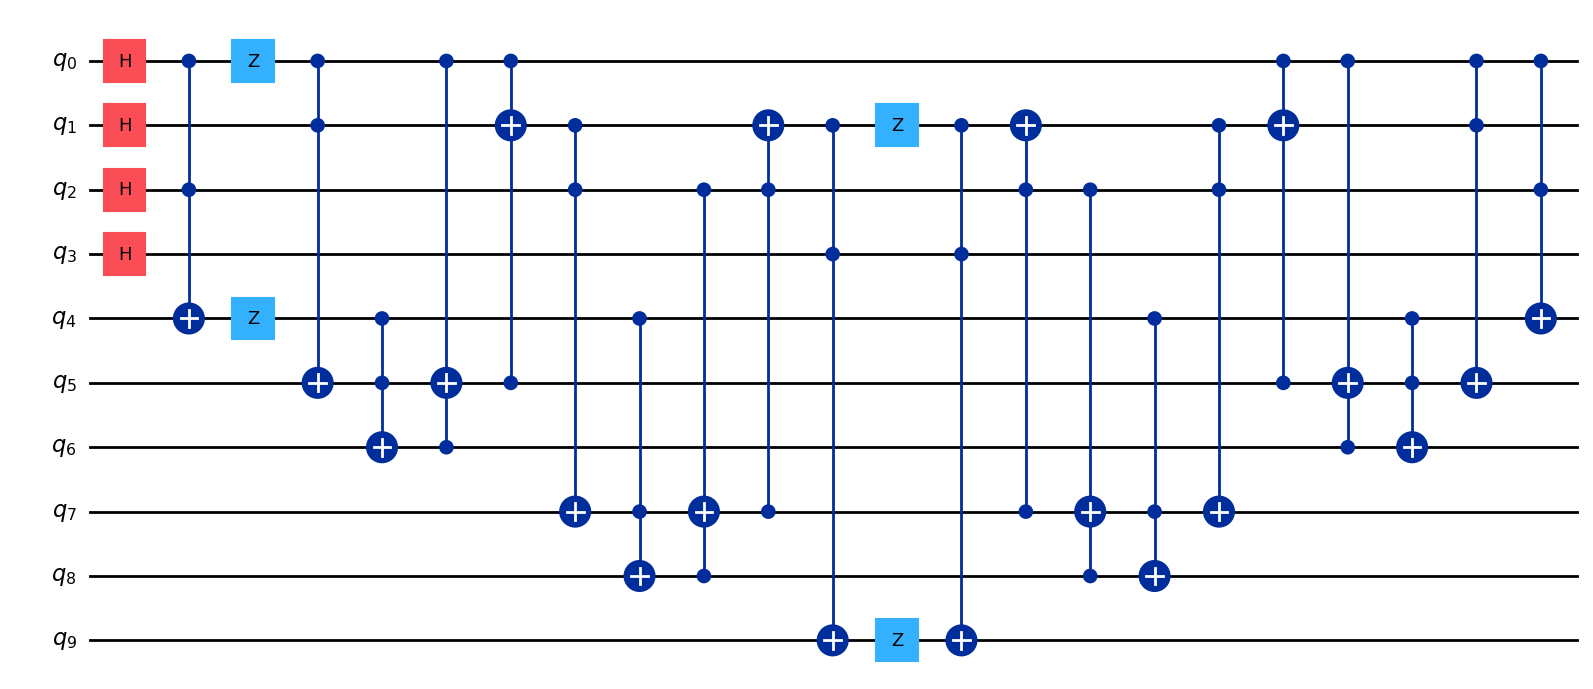

In [135]:
# ----- PARAMETERS -----
n = 2
m = 2 * n**2 - n

nq = 2 * n + m

# ----- SETUP -----
qc = QuantumCircuit(nq)

# Create a superposition of all states, to test that our algorithm works
for i in range(2*n):
    qc.h(i)

# Next ancilla qubit that has not been used yet
anc = 2*n

# Current 11 test
anc11 = -1

# Toffoli to revert at the end
revert = []



# ----- ALGORITHM -----
for i in range(n):

    # Get qubit indexes
    xi = i
    yi = i+n

    # Compare x_i with y_i
    qc.ccx(xi, yi, anc)
    qc.z(xi)
    qc.z(anc)

    # Accounting
    revert += [(xi, yi, anc)]
    anc11 = anc
    anc += 1

    # Set next qubits to zero if comparison terminated (remember j > i)
    for j in range(i+1, n):
        xj = j
        yj = j+n

        # Set all future xj = 0 if xi = 1 and yi is not 1
        qc.ccx(xi, xj, anc)
        revert += [(xi, xj, anc)]
        anc += 1

        qc.ccx(anc11, anc-1, anc)
        revert += [(anc11, anc-1, anc)]
        anc += 1

        qc.ccx(xi, anc-1, anc-2)
        revert += [(xi, anc-1, anc-2)]

        qc.ccx(xi, anc-2, xj)
        revert += [(xi, anc-2, xj)]

        
        # Set all future xj = 0 if yi = 1 and xi is not 1
        qc.ccx(yi, xj, anc)
        revert += [(yi, xj, anc)]
        anc += 1

        qc.ccx(anc11, anc-1, anc)
        revert += [(anc11, anc-1, anc)]
        anc += 1

        qc.ccx(yi, anc-1, anc-2)
        revert += [(yi, anc-1, anc-2)]

        qc.ccx(yi, anc-2, xj)
        revert += [(yi, anc-2, xj)]



# Revert Toffoli gates
for item in revert[::-1]:
    qc.ccx(item[0], item[1], item[2])



# ----- VISUALIZATION -----
print(f"Circuit for n = {n}")
print("Toffoli gates: ", len(revert) * 2)
qc.draw('mpl')

In [136]:
state, ok = test(qc, nq, n)

print(f"Circuit is {'OK!' if ok else "Not OK :("}\n")

print("Final state is:")
state.draw("latex")

Circuit is OK!

Final state is:


<IPython.core.display.Latex object>

## Version 2

Circuit for n = 2
Toffoli gates:  22


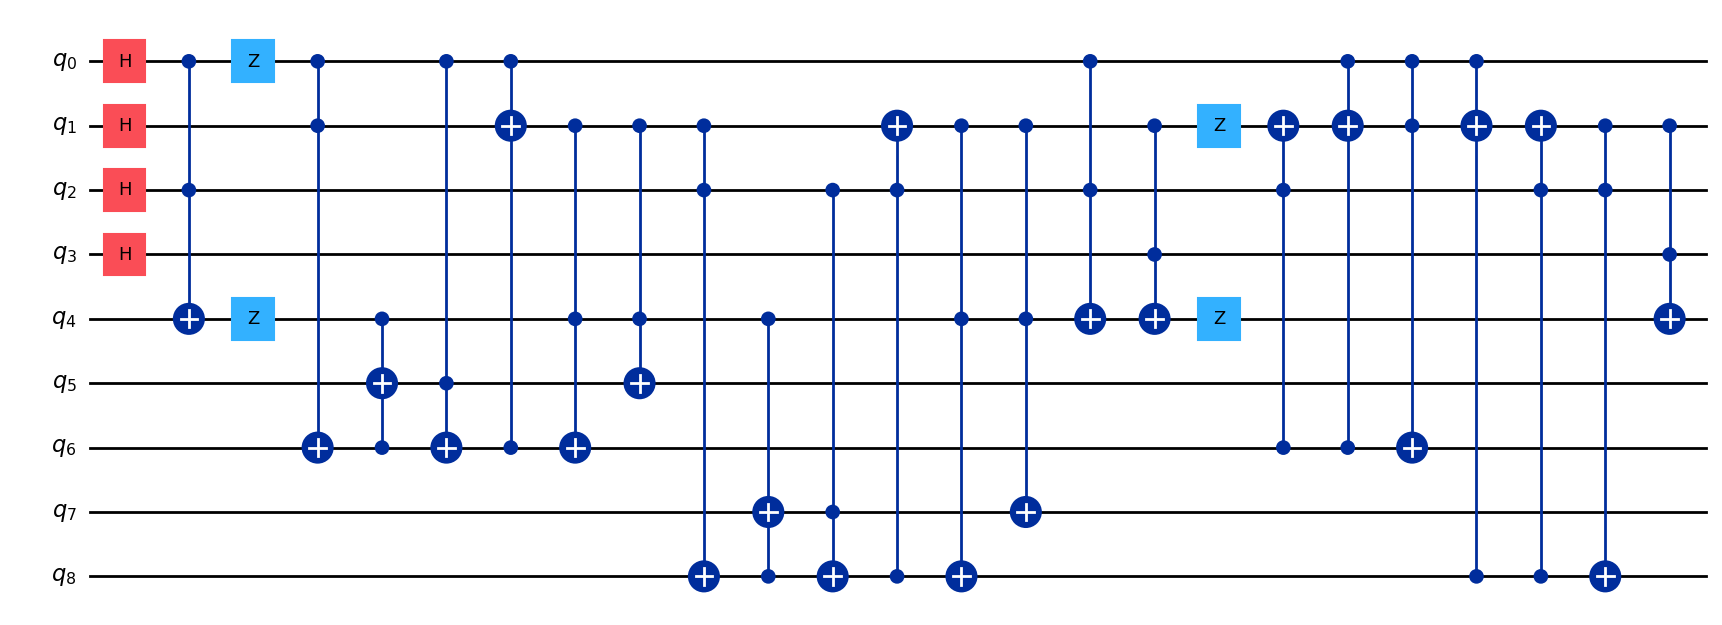

In [137]:
# ----- PARAMETERS -----
n = 2
m = 2 * n + 1

nq = 2 * n + m

# ----- SETUP -----
qc = QuantumCircuit(nq)

# Create a superposition of all states, to test that our algorithm works
for i in range(2*n):
    qc.h(i)


# Ancilla 0 stores the xi = 1 and yi = 1 Toffoli
anc0 = 2*n

# Ancill 2 is the one that gets cleared after every comparison
anc2 = 2*n + 1

# Next ancilla 1 that has not been used yet, needs to be kept until the end
anc1 = 2*n + 2

# Set of (q0, q1, q2, anc1)
uncompute = []



# ----- ALGORITHM -----
T = 0
for i in range(n):

    # Get qubit indexes
    xi = i
    yi = i+n

    # Compare x_i with y_i
    qc.ccx(xi, yi, anc0)
    T += 1

    qc.z(xi)
    qc.z(anc0)

    
    # Clear anc1 and reset xj
    for item in uncompute:
        q0, q1, q2, a1 = item

        qc.ccx(q2, a1, q1)
        qc.ccx(q0, a1, q1)
        qc.ccx(q0, q1, a1)

        T += 3

    
    # Reset for next round
    anc1 = 2*n + 2
    uncompute = []
    

    # Set next qubits to zero if comparison terminated (remember j > i)
    anc1 = 2*n + 2
    for j in range(i+1, n):
        xj = j
        yj = j+n

        # Set all future xj = 0 if xi = 1 and yi is not 1
        qc.ccx(xi, xj, anc1)
        qc.ccx(anc0, anc1, anc2)
        qc.ccx(xi, anc2, anc1)
        qc.ccx(xi, anc1, xj)
        T += 4

        # Clear anc2
        qc.ccx(xj, anc0, anc1)
        qc.ccx(xj, anc0, anc2)
        T += 2

        # Save to uncompute
        uncompute += [(xi, xj, yi, anc1)]


        # Move anc1 up by 1
        anc1 += 2
        anc2 += 2

        
        # Set all future xj = 0 if yi = 1 and xi is not 1
        qc.ccx(yi, xj, anc1)
        qc.ccx(anc0, anc1, anc2)
        qc.ccx(yi, anc2, anc1)
        qc.ccx(yi, anc1, xj)
        T += 4

        # Clear anc2
        qc.ccx(xj, anc0, anc1)
        qc.ccx(xj, anc0, anc2)
        T += 2

        # Save to uncompute
        uncompute += [(yi, xj, xi, anc1)]

        # Move anc1 up by 1
        anc1 += 2
        anc2 += 2
    

    # Clear anc0
    qc.ccx(xi, yi, anc0)
    T += 1



# ----- VISUALIZATION -----
print(f"Circuit for n = {n}")
print("Toffoli gates: ", T)
qc.draw('mpl')

In [138]:
state, ok = test(qc, nq, n)

print(f"Circuit is {'OK!' if ok else "Not OK :("}\n")

print("Final state is:")
state.draw("latex")

Error in sign for x = 3 and y = 1 (coeff = 0.0000)
Error in sign for x = 1 and y = 3 (coeff = 0.0000)
Error in ancillas for x = 3 and y = 1 (coeff = -0.2500 for state index = 000011011)
Error in ancillas for x = 1 and y = 3 (coeff = 0.2500 for state index = 000011110)
Circuit is Not OK :(

Final state is:


<IPython.core.display.Latex object>